**Connect Google Drive**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Pre-Processing


**Download RNA-seq data**

In [ ]:
import pandas as pd

# Load the cell line names
cell_line_path = '/content/drive/MyDrive/Colab Notebooks/ECSE 556/FinalProject/data/CellLineNames.csv'
df_cell_line_names = pd.read_csv(cell_line_path)

# Load the RNA-seq data
extracted_csv_path = '/content/drive/MyDrive/Colab Notebooks/ECSE 556/FinalProject/data/rnaseq_tpm_20220624.csv'
df_sample = pd.read_csv(extracted_csv_path)

# Drop unnecessary rows based on specific values in the first column
rows_to_drop = ['dataset_name', 'data_source', 'gene_id', 'model_name']
df_cleaned = df_sample[~df_sample.iloc[:, 0].isin(rows_to_drop)].copy()

# Transpose the matrix
df_transposed = df_cleaned.transpose()

# Set the first row as headers, then remove that row from the DataFrame
df_transposed.columns = df_transposed.iloc[0]  # Take the first row for the header
df_transposed = df_transposed[1:]              # Take the data below the header row

# Get the set of model IDs from df_cell_line_names
matched_model_ids = set(df_cell_line_names['Model ID'])

# Filter df_transposed to keep only the rows with indices that match model IDs in df_cell_line_names
df_transposed_filtered = df_transposed[df_transposed.index.isin(matched_model_ids)]


# Display the filtered DataFrame and count the number of matches
display(df_transposed_filtered.head())
print(f"Number of matching model_id rows in df_transposed: {len(df_transposed_filtered)}")

<ipython-input-2-ac3a5e81abdc>:9: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,2

model_id,SIDG00001,SIDG00002,SIDG00003,SIDG00004,SIDG00005,SIDG00006,SIDG00007,SIDG00008,SIDG00009,SIDG00010,...,SIDG42469,SIDG42470,SIDG42471,SIDG42472,SIDG42473,SIDG42474,SIDG42475,SIDG42479,SIDG42480,SIDG42481
SIDM00003,0.49,11.54,0.0,29.14,0.83,0.0,0.0,0.0,0.03,0.31,...,13.27,0.31,29.87,179.63,0.0,25.23,44.7,7.59,5.89,1.94
SIDM00023,0.14,0.03,0.2,0.0,0.3,0.03,0.0,0.1,0.0,0.17,...,11.69,0.0,33.96,71.27,0.0,20.14,21.09,19.73,2.03,1.62
SIDM00040,0.03,0.0,0.0,0.12,0.14,0.0,0.0,0.03,0.0,0.03,...,10.34,0.0,14.36,75.67,0.0,8.09,27.97,9.71,4.36,0.4
SIDM00041,0.66,9.84,0.0,0.04,6.59,0.0,0.12,0.04,0.0,0.31,...,11.39,0.08,41.57,526.97,0.0,22.28,39.79,2.17,6.2,0.81
SIDM00042,0.31,0.1,0.0,0.28,3.8,0.45,0.1,0.1,0.07,0.17,...,0.28,0.0,10.25,42.66,0.0,16.41,16.62,33.39,5.19,0.21


Number of matching model_id rows in df_transposed: 972


**RNA-seq Pre-processing using min-max scaling**

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Ensure all data is numeric (without overwriting headers)
df_transposed_filtered_numeric = df_transposed_filtered.apply(pd.to_numeric, errors='coerce')

# Drop any columns with all NaN values
df_transposed_filtered_numeric.dropna(axis=1, how='all', inplace=True)

# Filter out genes with low variability (standard deviation < 0.1)
# Calculate the standard deviation of each gene (column)
std_dev = df_transposed_filtered_numeric.std(axis=0)

# Keep only genes with a standard deviation >= 0.1
df_filtered_high_variability = df_transposed_filtered_numeric.loc[:, std_dev >= 0.1]

# Apply Min-Max Scaling and retain original column names
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(df_filtered_high_variability),
                           index=df_filtered_high_variability.index,
                           columns=df_filtered_high_variability.columns)

# Display the scaled data
display(data_scaled.head())
print(data_scaled.shape)

model_id,SIDG00001,SIDG00002,SIDG00003,SIDG00004,SIDG00005,SIDG00006,SIDG00007,SIDG00008,SIDG00009,SIDG00010,...,SIDG42468,SIDG42469,SIDG42470,SIDG42471,SIDG42472,SIDG42474,SIDG42475,SIDG42479,SIDG42480,SIDG42481
SIDM00003,0.053669,0.255933,0.000000,0.004674,0.038749,0.000000,0.000000,0.000000,0.008108,0.031762,...,0.129574,0.165503,0.017024,0.287961,0.179565,0.276532,0.352652,0.092717,0.153371,0.019571
SIDM00023,0.015334,0.000665,0.001471,0.000000,0.014006,0.000222,0.000000,0.013038,0.000000,0.017418,...,0.114249,0.145797,0.000000,0.330852,0.071244,0.215493,0.152601,0.249483,0.039741,0.016240
SIDM00040,0.003286,0.000000,0.000000,0.000019,0.006536,0.000000,0.000000,0.003911,0.000000,0.003074,...,0.023332,0.128960,0.000000,0.125315,0.075643,0.070992,0.210896,0.120093,0.108331,0.003539
SIDM00041,0.072289,0.218230,0.000000,0.000006,0.307656,0.000000,0.005249,0.005215,0.000000,0.031762,...,0.145846,0.142055,0.004393,0.410654,0.526780,0.241156,0.311049,0.022727,0.162496,0.007808
SIDM00042,0.033954,0.002218,0.000000,0.000045,0.177404,0.003323,0.004374,0.013038,0.018919,0.017418,...,0.246492,0.003492,0.000000,0.082215,0.042645,0.170764,0.114726,0.425878,0.132764,0.001562


(972, 31337)


**Conditional Data Download**

In [ ]:
import pandas as pd

# Load the cell line names
copy_number_path = '/content/drive/MyDrive/Colab Notebooks/ECSE 556/FinalProject/data/cnv_summary_20230303.csv'
df_cnv = pd.read_csv(copy_number_path)


# Load the RNA-seq data
mutation_path = '/content/drive/MyDrive/Colab Notebooks/ECSE 556/FinalProject/data/mutations_summary_20230202.csv'
df_mutation = pd.read_csv(mutation_path)

**Conditional Information Formatting**

In [ ]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Initialize the scaler and encoder
scaler = MinMaxScaler()
one_hot_encoder = OneHotEncoder(sparse_output=False)

# Drop unnecessary columns in CNV data
df_cnv_cleaned = df_cnv.drop(columns=['model_name', 'symbol', 'source', 'data_type'])
df_mutation_cleaned = df_mutation.drop(columns=['model_name', 'gene_symbol', 'rna_mutation', 'cdna_mutation', 'source'])


# Find the common cell lines across all datasets
rnaseq_cell_lines = set(data_scaled.index)
cnv_cell_lines = set(df_cnv_cleaned['model_id'])
mutation_cell_lines = set(df_mutation_cleaned['model_id'])

common_cell_lines = rnaseq_cell_lines.intersection(cnv_cell_lines).intersection(mutation_cell_lines)

# Filter RNA-seq data
rnaseq_filtered = data_scaled.loc[list(common_cell_lines)]

# Filter each dataset to keep only the common cell lines
rnaseq_filtered = data_scaled.loc[list(common_cell_lines)]
cnv_filtered = df_cnv_cleaned[df_cnv_cleaned['model_id'].isin(common_cell_lines)]
mutation_filtered = df_mutation_cleaned[df_mutation_cleaned['model_id'].isin(common_cell_lines)]

# One-hot encode the categorical 'cn_category' column in CNV data
cnv_category_encoded = one_hot_encoder.fit_transform(cnv_filtered[['cn_category']])
cnv_category_encoded_df = pd.DataFrame(cnv_category_encoded, columns=one_hot_encoder.get_feature_names_out(['cn_category']))
cnv_filtered = pd.concat([cnv_filtered.reset_index(drop=True), cnv_category_encoded_df], axis=1).drop(columns=['cn_category'])

# Scale numeric columns in CNV data (e.g., 'total_copy_number') to [0, 1] range
cnv_filtered[['total_copy_number']] = scaler.fit_transform(cnv_filtered[['total_copy_number']])

# One-hot encode the categorical 'effect' column in Mutation data
mutation_effect_encoded = one_hot_encoder.fit_transform(mutation_filtered[['effect']])
mutation_effect_encoded_df = pd.DataFrame(mutation_effect_encoded, columns=one_hot_encoder.get_feature_names_out(['effect']))
mutation_filtered = pd.concat([mutation_filtered.reset_index(drop=True), mutation_effect_encoded_df], axis=1).drop(columns=['effect'])

# Scale numeric columns in Mutation data (e.g., 'vaf') to [0, 1] range
mutation_filtered[['vaf']] = scaler.fit_transform(mutation_filtered[['vaf']])

# Aggregate CNV and mutation data by 'model_id' to create a single row per cell line
# For CNV, use mean values for total copy number and sum for the one-hot encoded categories per cell line
cnv_aggregated = cnv_filtered.groupby('model_id').agg(
    {'total_copy_number': 'mean', **{col: 'sum' for col in cnv_category_encoded_df.columns}}
)

# For mutation data, use mean values for VAF and sum for one-hot encoded categories per cell line
mutation_aggregated = mutation_filtered.groupby('model_id').agg(
    {'vaf': 'mean', **{col: 'sum' for col in mutation_effect_encoded_df.columns}}
)

# Ensure the indices match for merging
# rnaseq_filtered = rnaseq_filtered.sort_index()
cnv_aggregated = cnv_aggregated.sort_index()
mutation_aggregated = mutation_aggregated.sort_index()

# Concatenate the CNV and mutation data as conditional input
conditional_data = pd.concat([cnv_aggregated, mutation_aggregated], axis=1)
conditional_data = cnv_aggregated

print("Conditional Input:")
display(conditional_data)
print("\nRNA-seq Data:")
display(rnaseq_filtered)

Conditional Input:


,total_copy_number,cn_category_Amplification,cn_category_Deletion,cn_category_Gain,cn_category_Loss,cn_category_Neutral
model_id,,,,,,
SIDM00003,0.006415,0.0,1.0,155.0,100.0,505.0
SIDM00023,0.006382,21.0,2.0,174.0,216.0,306.0
SIDM00040,0.005735,28.0,2.0,11.0,243.0,435.0
SIDM00042,0.010262,13.0,5.0,75.0,75.0,551.0
SIDM00043,0.006774,14.0,1.0,30.0,95.0,579.0
...,...,...,...,...,...,...
SIDM01247,0.004184,0.0,0.0,42.0,25.0,694.0
SIDM01248,0.007349,31.0,3.0,38.0,90.0,599.0
SIDM01251,0.006656,19.0,6.0,212.0,142.0,382.0



RNA-seq Data:


model_id,SIDG00001,SIDG00002,SIDG00003,SIDG00004,SIDG00005,SIDG00006,SIDG00007,SIDG00008,SIDG00009,SIDG00010,...,SIDG42468,SIDG42469,SIDG42470,SIDG42471,SIDG42472,SIDG42474,SIDG42475,SIDG42479,SIDG42480,SIDG42481
SIDM00254,0.125958,0.126414,0.000000,0.000489,0.011671,0.000517,0.006124,0.056063,0.000000,0.018443,...,0.055962,0.084934,0.002197,0.425545,0.374285,0.061638,0.081427,0.215522,0.199588,0.016969
SIDM00794,0.037240,0.001774,0.000000,0.000000,0.008870,0.095245,0.000000,0.000000,0.010811,0.004098,...,0.725786,0.002370,0.000000,0.204488,0.201088,0.690850,0.263684,0.572185,0.230497,0.011139
SIDM01157,0.064622,0.188068,0.000000,0.000006,0.014472,0.183181,0.001750,0.005215,0.043243,0.039959,...,0.160740,0.003367,0.000000,0.195155,0.270833,0.265380,0.311303,0.160640,0.078893,0.006663
SIDM00044,0.113910,0.380350,0.000000,0.000000,0.000000,0.000000,0.001750,0.009126,0.010811,0.106557,...,0.162548,0.001871,0.000000,0.330537,0.361580,0.154215,0.408321,0.105888,0.058875,0.028524
SIDM00544,0.101862,0.366378,0.000000,0.000000,0.001867,0.000000,0.000000,0.005215,0.000000,0.004098,...,0.124322,0.006735,0.000000,0.262269,0.209974,0.221729,0.152262,0.252324,0.155726,0.017593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIDM00181,0.067908,0.206254,0.000000,0.000135,0.086835,0.000000,0.000000,0.000000,0.048649,0.007172,...,0.194404,0.146919,0.000000,0.251678,0.469961,0.168605,0.374428,0.110537,0.101266,0.011139
SIDM00413,0.198248,0.309603,0.000000,0.000005,0.032213,0.000000,0.005687,0.000000,0.000000,0.000000,...,0.092467,0.000374,0.000000,0.094169,0.011556,0.439381,0.207338,0.169809,0.064174,0.020612
SIDM00415,0.089814,0.238412,0.000000,0.000006,0.001867,0.000295,0.004812,0.009126,0.000000,0.054303,...,0.104348,0.002245,0.000000,0.134753,0.016204,0.137307,0.292239,0.274664,0.248455,0.022278
SIDM01000,0.143483,0.231093,0.000000,0.031279,0.055089,0.000000,0.000000,0.181226,0.000000,0.200820,...,0.109772,0.006111,0.000000,0.239513,0.113229,0.301835,0.101339,0.112862,0.242273,0.011243


# Non Conditional VAE Architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Encoder
def build_encoder(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Dense(1024, activation="relu")(inputs)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    return tf.keras.Model(inputs, [z_mean, z_log_var], name="encoder")

# Sampling Layer remains the same
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Decoder
def build_decoder(output_shape):
    latent_inputs = tf.keras.Input(shape=(latent_dim,))
    x = layers.Dense(256, activation="relu")(latent_inputs)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(1024, activation="relu")(x)
    outputs = layers.Dense(output_shape, activation="sigmoid")(x)  # Use sigmoid if data is normalized to [0,1]
    return tf.keras.Model(latent_inputs, outputs, name="decoder")


**Build VAE**

In [ ]:
# Set a scaling factor for KL divergence
beta = 0.01  # Choose a value <1 to reduce KL divergence impact

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling((z_mean, z_log_var))
        reconstructed = self.decoder(z)

        # Calculate KL divergence loss and scale by beta
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        self.add_loss(beta * kl_loss)  # Scale the KL divergence term by beta
        return reconstructed

# Define your custom VAE loss function
def vae_loss(inputs, outputs):
    # MSE for reconstruction loss
    reconstruction_loss = tf.reduce_mean(tf.square(inputs - outputs))
    return reconstruction_loss  # The KL divergence is already added as a model loss


# VAE Cross Validation

Training on fold 1/5
Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - loss: 0.2585
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0211
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0153
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0142
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0133
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0130
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0131
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0125
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0126
Epoch 10/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0125
Epoch 11/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0124
Epoch 12/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0120
Epoch 13/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0120
Epoch 14/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0119
Epoch 15/200
12/12 ━━━━━━━━━━━━━━━━

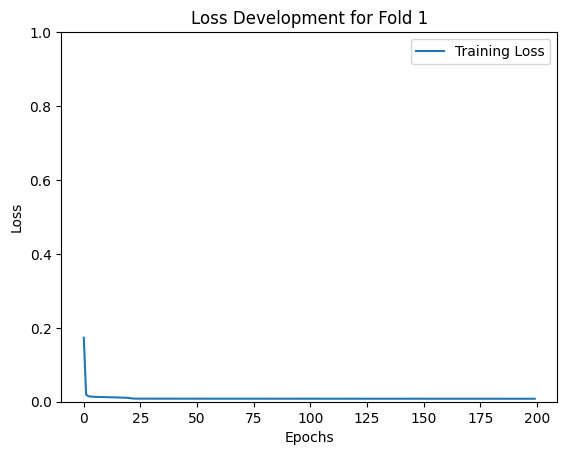

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Saved latent representations and loss plot for fold 1
Training on fold 2/5
Epoch 1/200


RuntimeError: pybind11::error_already_set: MISMATCH of original and normalized active exception types: ORIGINAL ResourceExhaustedError REPLACED BY KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/errors_impl.py(377): __init__
  /usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py(53): quick_execute
  /usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py(1552): call_function
  /usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(251): call_flat
  /usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(216): call_preflattened
  /usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/concrete_function.py(1322): _call_flat
  /usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(919): _call
  /usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(833): __call__
  /usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py(150): error_handler
  /usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py(320): fit
  /usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py(117): error_handler
  <ipython-input-21-817aade96e84>(66): <cell line: 49>
  /usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py(3553): run_code
  /usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py(3473): run_ast_nodes
  /usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py(3257): run_cell_async
  /usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py(78): _pseudo_sync_runner
  /usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py(3030): _run_cell
  /usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py(2975): run_cell
  /usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py(539): run_cell
  /usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py(302): do_execute
  /usr/local/lib/python3.10/dist-packages/tornado/gen.py(234): wrapper
  /usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py(539): execute_request
  /usr/local/lib/python3.10/dist-packages/tornado/gen.py(234): wrapper
  /usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py(261): dispatch_shell
  /usr/local/lib/python3.10/dist-packages/tornado/gen.py(234): wrapper
  /usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py(361): process_one
  /usr/local/lib/python3.10/dist-packages/tornado/gen.py(786): run
  /usr/local/lib/python3.10/dist-packages/tornado/gen.py(825): inner
  /usr/local/lib/python3.10/dist-packages/tornado/ioloop.py(738): _run_callback
  /usr/local/lib/python3.10/dist-packages/tornado/ioloop.py(685): <lambda>
  /usr/lib/python3.10/asyncio/events.py(80): _run
  /usr/lib/python3.10/asyncio/base_events.py(1909): _run_once
  /usr/lib/python3.10/asyncio/base_events.py(603): run_forever
  /usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py(195): start
  /usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py(619): start
  /usr/local/lib/python3.10/dist-packages/traitlets/config/application.py(992): launch_instance
  /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py(37): <module>
  /usr/lib/python3.10/runpy.py(86): _run_code
  /usr/lib/python3.10/runpy.py(196): _run_module_as_main


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import os

# Assuming rnaseq_filtered is already loaded and indexed by SANGER_MODEL_ID
X = rnaseq_filtered.values  # Convert to numpy for compatibility with KFold
index = rnaseq_filtered.index  # Store the original index

# Define the number of folds for cross-validation
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the VAE model dimensions
input_shape = (31337,)  # Update this to match your actual input shape
latent_dim = 45  # Adjust the latent dimension as needed

# Iterate over each fold
for fold, (train_idx, test_idx) in enumerate(kfold.split(X)):
    print(f"Training on fold {fold+1}/{n_splits}")

    # Split the data and keep the indices for alignment
    X_train, X_test = X[train_idx], X[test_idx]
    train_indices, test_indices = index[train_idx], index[test_idx]

    # Build and compile the VAE
    encoder = build_encoder(input_shape)
    decoder = build_decoder(input_shape[0])
    vae = VAE(encoder, decoder)

    learning_rate = 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    vae.compile(optimizer=optimizer, loss=vae_loss)

    # Train the VAE on the training data
    history = vae.fit(X_train, X_train, epochs=200, batch_size=64, verbose=1)

    # Get only the mean latent representations for training and test sets
    train_latent_vectors, _ = encoder.predict(X_train)
    test_latent_vectors, _ = encoder.predict(X_test)

    # Convert latent vectors to DataFrames with original indices
    train_latent_df = pd.DataFrame(train_latent_vectors, index=train_indices)
    test_latent_df = pd.DataFrame(test_latent_vectors, index=test_indices)

    # Define paths for saving CSV files
    train_path = f'/content/drive/MyDrive/Colab Notebooks/ECSE 556/FinalProject/output/space/latent_vectors_train_latent=45_fold={fold+1}.csv'
    test_path = f'/content/drive/MyDrive/Colab Notebooks/ECSE 556/FinalProject/output/space/latent_vectors_test_latent=45_fold={fold+1}.csv'

    # Ensure directories exist
    os.makedirs(os.path.dirname(train_path), exist_ok=True)
    os.makedirs(os.path.dirname(test_path), exist_ok=True)

    # Save the latent vectors as CSV files with indices
    train_latent_df.to_csv(train_path)
    test_latent_df.to_csv(test_path)

    print(f"Saved latent representations for fold {fold+1}")


# Prediction non Conditional

**Sensitivity labels creation binary**

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display

# Load the GDSC data
file_path_GDSC = '/content/drive/MyDrive/Colab Notebooks/ECSE 556/FinalProject/data/GDSC1_fitted_dose_response_27Oct23.xlsx'
df_GDSC = pd.read_excel(file_path_GDSC)

# Filter and preprocess GDSC data
df_GDSC_filtered = df_GDSC[['SANGER_MODEL_ID', 'LN_IC50', 'MAX_CONC', 'DRUG_ID', 'DRUG_NAME']].drop_duplicates(
    subset=['SANGER_MODEL_ID', 'DRUG_ID'])

# Normalize LN_IC50 and create sensitivity labels (performed only once)
df_GDSC_filtered['Normalized_IC50'] = df_GDSC_filtered.apply(
    lambda row: np.log(np.exp(row['LN_IC50']) / row['MAX_CONC']) if pd.notnull(row['LN_IC50']) else np.nan, axis=1
)

# Define sensitivity labels by drug based on the 30th percentile
df_GDSC_filtered['Sensitivity_Label'] = df_GDSC_filtered.groupby('DRUG_ID', group_keys=False).apply(
    lambda df: df['Normalized_IC50'].apply(lambda x: 'sensitive' if x <= df['Normalized_IC50'].quantile(0.30) else 'resistant')
)

# Keep only the relevant columns after processing, replacing LN_IC50 with Normalized_IC50
df_GDSC_filtered = df_GDSC_filtered[['SANGER_MODEL_ID', 'DRUG_ID', 'DRUG_NAME', 'Normalized_IC50', 'Sensitivity_Label']]


<ipython-input-11-e7dea686d327>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_GDSC_filtered['Sensitivity_Label'] = df_GDSC_filtered.groupby('DRUG_ID', group_keys=False).apply(


**Sensitivity label creation 3 groups**

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display

# Load the GDSC data
file_path_GDSC = '/content/drive/MyDrive/Colab Notebooks/ECSE 556/FinalProject/data/GDSC1_fitted_dose_response_27Oct23.xlsx'
df_GDSC = pd.read_excel(file_path_GDSC)

# Filter and preprocess GDSC data
df_GDSC_filtered = df_GDSC[['SANGER_MODEL_ID', 'LN_IC50', 'MAX_CONC', 'DRUG_ID', 'DRUG_NAME']].drop_duplicates(
    subset=['SANGER_MODEL_ID', 'DRUG_ID'])

# Normalize LN_IC50 and create sensitivity labels
df_GDSC_filtered['Normalized_IC50'] = df_GDSC_filtered.apply(
    lambda row: np.log(np.exp(row['LN_IC50']) / row['MAX_CONC']) if pd.notnull(row['LN_IC50']) else np.nan, axis=1
)

# Define sensitivity labels by drug based on percentiles
def assign_sensitivity_label(df):
    lower_bound = df['Normalized_IC50'].quantile(0.30)
    upper_bound = df['Normalized_IC50'].quantile(0.70)
    return df['Normalized_IC50'].apply(
        lambda x: 'sensitive' if x <= lower_bound else 'resistant' if x > upper_bound else 'intermediate'
    )

df_GDSC_filtered['Sensitivity_Label'] = df_GDSC_filtered.groupby('DRUG_ID', group_keys=False).apply(assign_sensitivity_label)

# Keep only the relevant columns after processing
df_GDSC_filtered = df_GDSC_filtered[['SANGER_MODEL_ID', 'DRUG_ID', 'DRUG_NAME', 'Normalized_IC50', 'Sensitivity_Label']]

# Display the resulting dataframe
display(df_GDSC_filtered)

<ipython-input-2-5413bed8535c>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_GDSC_filtered['Sensitivity_Label'] = df_GDSC_filtered.groupby('DRUG_ID', group_keys=False).apply(assign_sensitivity_label)


,SANGER_MODEL_ID,DRUG_ID,DRUG_NAME,Normalized_IC50,Sensitivity_Label
0,SIDM00263,1,Erlotinib,3.273666,resistant
1,SIDM00269,1,Erlotinib,1.998943,intermediate
2,SIDM00203,1,Erlotinib,1.784843,intermediate
3,SIDM01111,1,Erlotinib,1.340417,sensitive
4,SIDM00909,1,Erlotinib,2.272860,intermediate
...,...,...,...,...,...
333156,SIDM00217,1531,I-CBP112,2.782709,resistant
333157,SIDM00194,1531,I-CBP112,3.422814,resistant
333158,SIDM00193,1531,I-CBP112,2.628168,resistant
333159,SIDM00498,1531,I-CBP112,2.249199,intermediate


**Prediction Task**

In [ ]:
import torch
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Helper function to perform Kernel Ridge Regression using Torch
def kernel_ridge_regression(X_train, y_train, X_test, alpha=1.0, gamma=0.1):
    # Compute the RBF kernel
    K_train = torch.exp(-gamma * torch.cdist(X_train, X_train) ** 2)
    K_test = torch.exp(-gamma * torch.cdist(X_test, X_train) ** 2)

    # Compute alpha (ridge) regularized weights
    n = K_train.size(0)
    ridge = alpha * torch.eye(n, device='cuda')
    alpha_weights = torch.linalg.solve(K_train + ridge, y_train)

    # Predict on test data
    y_pred = K_test @ alpha_weights
    return y_pred

# Set paths and parameters
n_splits = 5
drug_roc_data_vae = {}
train_mse_per_fold = []
test_mse_per_fold = []

# Perform K-fold cross-validation
for fold in range(1, n_splits + 1):
    print(f"Processing fold {fold}/{n_splits}")

    # Load train and test latent vectors for this fold
    train_path = f'/content/drive/MyDrive/Colab Notebooks/ECSE 556/FinalProject/output/space/latent_vectors_train_latent=30_fold={fold}.csv'
    test_path = f'/content/drive/MyDrive/Colab Notebooks/ECSE 556/FinalProject/output/space/latent_vectors_test_latent=30_fold={fold}.csv'

    df_train = pd.read_csv(train_path, index_col='Unnamed: 0')
    df_test = pd.read_csv(test_path, index_col='Unnamed: 0')

    # Filter preprocessed `df_GDSC_filtered` for matching SANGER_MODEL_IDs
    matching_ids = set(df_train.index).union(set(df_test.index))
    df_GDSC_fold = df_GDSC_filtered[df_GDSC_filtered['SANGER_MODEL_ID'].isin(matching_ids)]

    # Merge GDSC data with train and test latent vectors
    df_train_merged = pd.merge(df_train, df_GDSC_fold, left_index=True, right_on='SANGER_MODEL_ID', how='inner')
    df_test_merged = pd.merge(df_test, df_GDSC_fold, left_index=True, right_on='SANGER_MODEL_ID', how='inner')

    # Initialize MSE tracking for this fold
    train_mse_per_drug = []
    test_mse_per_drug = []

    # Loop over each unique drug and collect predictions and labels across folds
    for drug in df_GDSC_fold['DRUG_NAME'].unique():
        print(f"  Processing drug: {drug}")

        # Initialize storage for each drug if not already initialized
        if drug not in drug_roc_data_vae:
            drug_roc_data_vae[drug] = {"y_true": [], "y_pred": []}

        # Filter data for the current drug
        df_train_drug = df_train_merged[df_train_merged['DRUG_NAME'] == drug]
        df_test_drug = df_test_merged[df_test_merged['DRUG_NAME'] == drug]

        # Extract features and target
        X_train = df_train_drug.drop(columns=['SANGER_MODEL_ID', 'DRUG_ID', 'DRUG_NAME', 'Sensitivity_Label', 'Normalized_IC50']).values
        y_train = df_train_drug['Normalized_IC50'].values
        X_test = df_test_drug.drop(columns=['SANGER_MODEL_ID', 'DRUG_ID', 'DRUG_NAME', 'Sensitivity_Label', 'Normalized_IC50']).values
        y_test = df_test_drug['Normalized_IC50'].values

        # Extract sensitivity labels for ROC curve
        y_test_labels = df_test_drug['Sensitivity_Label'].map({'sensitive': 1, 'resistant': 0}).values

        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Convert data to torch tensors and transfer to GPU
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32, device='cuda')
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device='cuda')
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32, device='cuda')

        # Perform Kernel Ridge Regression
        y_test_pred_tensor = kernel_ridge_regression(X_train_tensor, y_train_tensor, X_test_tensor)
        y_test_pred = y_test_pred_tensor.cpu().detach().numpy()

        # Append the predictions and labels for the current drug
        drug_roc_data_vae[drug]["y_true"].extend(y_test_labels)
        drug_roc_data_vae[drug]["y_pred"].extend(y_test_pred)

        # Calculate MSE for training and test sets
        y_train_pred_tensor = kernel_ridge_regression(X_train_tensor, y_train_tensor, X_train_tensor)
        y_train_pred = y_train_pred_tensor.cpu().detach().numpy()
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)

        train_mse_per_drug.append(train_mse)
        test_mse_per_drug.append(test_mse)

    # Calculate and store average MSE for this fold
    fold_train_mse = np.mean(train_mse_per_drug)
    fold_test_mse = np.mean(test_mse_per_drug)
    train_mse_per_fold.append(fold_train_mse)
    test_mse_per_fold.append(fold_test_mse)

    print(f"Average Train MSE for fold {fold}: {fold_train_mse}")
    print(f"Average Test MSE for fold {fold}: {fold_test_mse}")

# Calculate and print overall average MSE across all folds
average_train_mse = np.mean(train_mse_per_fold)
average_test_mse = np.mean(test_mse_per_fold)

print("\nOverall Average Train MSE:", average_train_mse)
print("Overall Average Test MSE:", average_test_mse)

# Initialize storage for AUC values
auc_values_vae = []  # To collect AUC values for all drugs

# Compute AUC for all drugs in the VAE data
for drug, data in drug_roc_data_vae.items():
    y_true = np.array(data["y_true"])
    y_pred = np.array(data["y_pred"])

    if len(np.unique(y_true)) > 1:  # Ensure both classes are present
        auc = roc_auc_score(y_true, y_pred)
        auc_values_vae.append(auc)  # Collect AUC value

        if auc >= 0.6 or auc <= 0.4:
            fpr, tpr, _ = roc_curve(y_true, y_pred)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", color='blue')
            plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.7)
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curve for {drug}")
            plt.legend()
            plt.grid(alpha=0.3)
            plt.show()

# Calculate and print the average AUC for VAE
average_auc_vae = np.mean(auc_values_vae)
print(f"Average AUC across all drugs (VAE): {average_auc_vae:.4f}")


Processing fold 1/5
  Processing drug: Erlotinib
  Processing drug: Rapamycin
  Processing drug: Sunitinib
  Processing drug: PHA-665752
  Processing drug: MG-132
  Processing drug: Paclitaxel
  Processing drug: Cyclopamine
  Processing drug: AZ628
  Processing drug: Sorafenib
  Processing drug: Tozasertib
  Processing drug: Imatinib
  Processing drug: NVP-TAE684
  Processing drug: Crizotinib
  Processing drug: Saracatinib
  Processing drug: S-Trityl-L-cysteine
  Processing drug: Z-LLNle-CHO
  Processing drug: Dasatinib
  Processing drug: GNF-2
  Processing drug: CGP-60474
  Processing drug: CGP-082996
  Processing drug: A-770041
  Processing drug: WH-4-023
  Processing drug: WZ-1-84
  Processing drug: BI-2536
  Processing drug: BMS-536924
  Processing drug: BMS-509744
  Processing drug: CMK
  Processing drug: Pyrimethamine
  Processing drug: JW-7-52-1
  Processing drug: A-443654
  Processing drug: GW843682X
  Processing drug: Entinostat
  Processing drug: Parthenolide
  Processing dru

# Conditional VAE

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import mse

class ConditionalVAE(tf.keras.Model):
    def __init__(self, input_dim, cond_dim, latent_dim, beta=1.0):
        super(ConditionalVAE, self).__init__()

        # Define dimensions
        self.input_dim = input_dim
        self.cond_dim = cond_dim
        self.latent_dim = latent_dim
        self.beta = beta  # Scaling factor for KL divergence

        # Encoder layers
        self.encoder_fc1 = layers.Dense(1024, activation='relu')
        self.encoder_fc2 = layers.Dense(512, activation='relu')
        self.encoder_fc3 = layers.Dense(256, activation='relu')

        # Latent space: mean and log-variance layers
        self.fc_mu = layers.Dense(latent_dim)
        self.fc_logvar = layers.Dense(latent_dim)

        # Decoder layers
        self.decoder_fc1 = layers.Dense(256, activation='relu')
        self.decoder_fc2 = layers.Dense(512, activation='relu')
        self.decoder_fc3 = layers.Dense(1024, activation='relu')
        self.decoder_fc4 = layers.Dense(input_dim, activation='sigmoid')  # Use sigmoid if input is in range [0, 1]

        # Add a loss tracker for logging
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def encode(self, x, c):
        # Concatenate input data and condition
        x_cond = layers.concatenate([x, c])

        # Pass through encoder layers
        h = self.encoder_fc1(x_cond)
        h = self.encoder_fc2(h)
        h = self.encoder_fc3(h)

        # Generate mean and log-variance for the latent space
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Sample from the latent space using reparameterization trick
        std = tf.exp(0.5 * logvar)
        eps = tf.random.normal(shape=tf.shape(std))
        return mu + eps * std

    def decode(self, z, c):
        # Concatenate latent variable and condition
        z_cond = layers.concatenate([z, c])

        # Pass through decoder layers
        h = self.decoder_fc1(z_cond)
        h = self.decoder_fc2(h)
        h = self.decoder_fc3(h)
        recon_x = self.decoder_fc4(h)
        return recon_x

    def call(self, x, c):
        # Encode x to obtain mu and logvar
        mu, logvar = self.encode(x, c)

        # Reparameterize to get latent variable z
        z = self.reparameterize(mu, logvar)

        # Decode z to reconstruct x
        recon_x = self.decode(z, c)

        return recon_x, mu, logvar

    def train_step(self, data):
        x, c = data  # Unpack the tuple

        with tf.GradientTape() as tape:
            # Forward pass
            recon_x, mu, logvar = self(x, c)
            # Compute loss
            loss = self.compute_loss(x, recon_x, mu, logvar)

        # Compute gradients and apply them
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Log the loss
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

    def compute_loss(self, x, recon_x, mu, logvar):
        # Reconstruction loss (e.g., MSE or binary cross-entropy depending on your input data)
        reconstruction_loss = mse(x, recon_x) * x.shape[1]

        # KL divergence
        kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar), axis=-1)

        # Total VAE loss with adjustable beta for KL divergence
        total_loss = tf.reduce_mean(reconstruction_loss + self.beta * kl_loss)
        return total_loss

    def get_latent_vectors(self, x, c):
        # Encode and get the latent vectors (mu)
        mu, _ = self.encode(x, c)
        return mu


# KFold cVAE Training

**Align the rna data with the conditional data**

In [ ]:
import numpy as np
# Sort both DataFrames by their index (SANGER_MODEL_ID)
rnaseq_filtered_sorted = rnaseq_filtered.sort_index()
conditional_data_sorted = conditional_data.sort_index()

# Align RNA-seq and conditional data based on cell line (SANGER_MODEL_ID)
merged_data = pd.merge(
    rnaseq_filtered_sorted, conditional_data_sorted, left_index=True, right_index=True, how="inner"
)

# Separate the merged data back into RNA-seq and conditional data
X = merged_data[rnaseq_filtered.columns].values  # RNA-seq data as numpy array
C = merged_data[conditional_data.columns].values  # Conditional data as numpy array
index = merged_data.index  # Store the original cell line indices

# Confirm alignment
print("RNA-seq data shape:", X.shape)
print("Conditional data shape:", C.shape)
print("Index alignment:", np.array_equal(rnaseq_filtered_sorted.index, conditional_data_sorted.index))

NameError: name 'rnaseq_filtered' is not defined

Training on fold 1/5
Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 415ms/step - loss: 20158.7969
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 300.9039
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 279.6024
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 262.3142
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 261.8752
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 258.8677
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 259.0316
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 257.9359
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 257.5592
Epoch 10/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 257.1042
Epoch 11/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 256.5345
Epoch 12/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 255.5190
Epoch 13/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 253.6242
Epoch 14/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 248.2966
Epoc

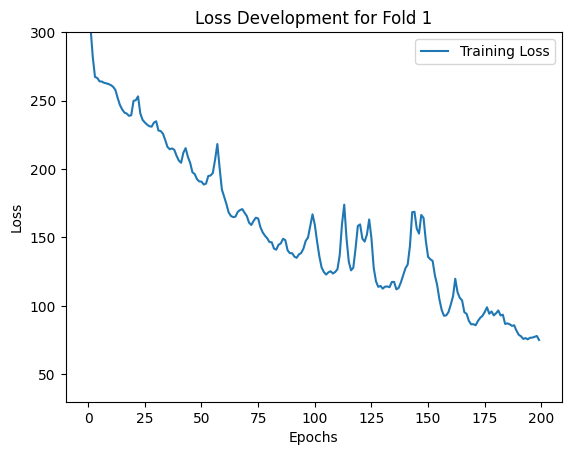

Saved latent representations and loss plot for fold 1
Training on fold 2/5
Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 335ms/step - loss: 3391.5596
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 280.3930
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 271.7657
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 272.3722
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 260.6809
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 259.9384
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 258.9158
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 257.9504
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 257.6104
Epoch 10/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 254.8242
Epoch 11/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 250.8595
Epoch 12/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 247.9491
Epoch 13/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 250.0386
Epoch 14/200
12/12 ━━━

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import os

# Set dimensions for cVAE
input_dim = 31337  # Dimension of RNA-seq data
cond_dim = 6      # Dimension of conditional data
latent_dim = 15   # Latent space dimension
beta = 0.01      # Beta for KL divergence

# Prepare k-fold cross-validation
X = rnaseq_filtered.values  # RNA-seq data as numpy array
C = conditional_data.values  # Conditional data as numpy array
index = rnaseq_filtered.index  # Store original indices

n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Iterate over each fold
for fold, (train_idx, test_idx) in enumerate(kfold.split(X)):
    print(f"Training on fold {fold+1}/{n_splits}")

    # Split RNA-seq data and conditional data for this fold
    X_train, X_test = X[train_idx], X[test_idx]
    C_train, C_test = C[train_idx], C[test_idx]
    train_indices, test_indices = index[train_idx], index[test_idx]

    # Instantiate and compile the cVAE for each fold
    cvae = ConditionalVAE(input_dim=input_dim, cond_dim=cond_dim, latent_dim=latent_dim, beta=beta)
    cvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

    # Create TensorFlow Dataset with both RNA-seq and conditional data for training
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, C_train)).batch(64)

    # Train the cVAE and capture the history
    history = cvae.fit(train_dataset, epochs=200, verbose=1)

    # Plot the loss development
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title(f'Loss Development for Fold {fold+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(30, 300)  # Set the y-axis range to focus on 200
    plt.legend()
    plt.show()

    # Extract latent vectors for training and test sets
    train_latent_vectors = cvae.get_latent_vectors(X_train, C_train)
    test_latent_vectors = cvae.get_latent_vectors(X_test, C_test)

    # Convert latent vectors to DataFrames with original indices
    train_latent_df = pd.DataFrame(train_latent_vectors, index=train_indices)
    test_latent_df = pd.DataFrame(test_latent_vectors, index=test_indices)

    # Define paths for saving CSV files
    train_path = f'/content/drive/MyDrive/Colab Notebooks/ECSE 556/FinalProject/output/ablation/cnv_latent_vectors_dense_train_latent=50_fold={fold+1}.csv'
    test_path = f'/content/drive/MyDrive/Colab Notebooks/ECSE 556/FinalProject/output/ablation/cnv_latent_vectors_dense_test_latent=50_fold={fold+1}.csv'

    # Ensure directories exist
    os.makedirs(os.path.dirname(train_path), exist_ok=True)
    os.makedirs(os.path.dirname(test_path), exist_ok=True)


    # Save the latent vectors as CSV files with indices
    train_latent_df.to_csv(train_path)
    test_latent_df.to_csv(test_path)

    print(f"Saved latent representations and loss plot for fold {fold+1}")


In [ ]:
import torch
from sklearn.metrics import (
    mean_squared_error,
    precision_recall_curve,
    average_precision_score,
    roc_auc_score
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Helper function to perform Kernel Ridge Regression using Torch
def kernel_ridge_regression(X_train, y_train, X_test, alpha=1.0, gamma=0.1):
    # Compute the RBF kernel
    K_train = torch.exp(-gamma * torch.cdist(X_train, X_train) ** 2)
    K_test = torch.exp(-gamma * torch.cdist(X_test, X_train) ** 2)

    # Compute alpha (ridge) regularized weights
    n = K_train.size(0)
    ridge = alpha * torch.eye(n, device='cuda')
    alpha_weights = torch.linalg.solve(K_train + ridge, y_train)

    # Predict on test data
    y_pred = K_test @ alpha_weights
    return y_pred

# Set paths and parameters
n_splits = 5
drug_metrics_data = {}  # Store metrics (PR and ROC)
train_mse_per_fold = []
test_mse_per_fold = []

# Perform K-fold cross-validation
for fold in range(1, n_splits + 1):
    print(f"Processing fold {fold}/{n_splits}")

    # Load train and test latent vectors for this fold
    train_path = f'/content/drive/MyDrive/Colab Notebooks/ECSE 556/FinalProject/output/ablation/latent_vectors_train_latent=15_fold={fold}.csv'
    test_path = f'/content/drive/MyDrive/Colab Notebooks/ECSE 556/FinalProject/output/ablation/latent_vectors_test_latent=15_fold={fold}.csv'

    df_train = pd.read_csv(train_path, index_col='Unnamed: 0')
    df_test = pd.read_csv(test_path, index_col='Unnamed: 0')

    # Filter preprocessed `df_GDSC_filtered` for matching SANGER_MODEL_IDs
    matching_ids = set(df_train.index).union(set(df_test.index))
    df_GDSC_fold = df_GDSC_filtered[df_GDSC_filtered['SANGER_MODEL_ID'].isin(matching_ids)]

    # Merge GDSC data with train and test latent vectors
    df_train_merged = pd.merge(df_train, df_GDSC_fold, left_index=True, right_on='SANGER_MODEL_ID', how='inner')
    df_test_merged = pd.merge(df_test, df_GDSC_fold, left_index=True, right_on='SANGER_MODEL_ID', how='inner')

    # Initialize MSE tracking for this fold
    train_mse_per_drug = []
    test_mse_per_drug = []

    # Loop over each unique drug and collect predictions and labels across folds
    for drug in df_GDSC_fold['DRUG_NAME'].unique():
        print(f"  Processing drug: {drug}")

        # Initialize storage for each drug if not already initialized
        if drug not in drug_metrics_data:
            drug_metrics_data[drug] = {"y_true": [], "y_pred": []}

        # Filter data for the current drug
        df_train_drug = df_train_merged[df_train_merged['DRUG_NAME'] == drug]
        df_test_drug = df_test_merged[df_test_merged['DRUG_NAME'] == drug]

        # Extract features and target
        X_train = df_train_drug.drop(columns=['SANGER_MODEL_ID', 'DRUG_ID', 'DRUG_NAME', 'Sensitivity_Label', 'Normalized_IC50']).values
        y_train_labels = df_train_drug['Sensitivity_Label'].map({'sensitive': 1, 'resistant': 0}).values
        X_test = df_test_drug.drop(columns=['SANGER_MODEL_ID', 'DRUG_ID', 'DRUG_NAME', 'Sensitivity_Label', 'Normalized_IC50']).values
        y_test_labels = df_test_drug['Sensitivity_Label'].map({'sensitive': 1, 'resistant': 0}).values

        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Convert data to torch tensors and transfer to GPU
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32, device='cuda')
        y_train_labels_tensor = torch.tensor(y_train_labels, dtype=torch.float32, device='cuda')
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32, device='cuda')

        # Perform Kernel Ridge Regression
        y_test_pred_tensor = kernel_ridge_regression(X_train_tensor, y_train_labels_tensor, X_test_tensor)
        y_test_pred = y_test_pred_tensor.cpu().detach().numpy()

        # Append the predictions and labels for the current drug
        drug_metrics_data[drug]["y_true"].extend(y_test_labels)
        drug_metrics_data[drug]["y_pred"].extend(y_test_pred)

        # Calculate MSE for training and test sets
        y_train_pred_tensor = kernel_ridge_regression(X_train_tensor, y_train_labels_tensor, X_train_tensor)
        y_train_pred = y_train_pred_tensor.cpu().detach().numpy()
        train_mse = mean_squared_error(y_train_labels, y_train_pred)
        test_mse = mean_squared_error(y_test_labels, y_test_pred)

        train_mse_per_drug.append(train_mse)
        test_mse_per_drug.append(test_mse)

    # Calculate and store average MSE for this fold
    fold_train_mse = np.mean(train_mse_per_drug)
    fold_test_mse = np.mean(test_mse_per_drug)
    train_mse_per_fold.append(fold_train_mse)
    test_mse_per_fold.append(fold_test_mse)

    print(f"Average Train MSE for fold {fold}: {fold_train_mse}")
    print(f"Average Test MSE for fold {fold}: {fold_test_mse}")

# Calculate and print overall average MSE across all folds
average_train_mse = np.mean(train_mse_per_fold)
average_test_mse = np.mean(test_mse_per_fold)

print("\nOverall Average Train MSE:", average_train_mse)
print("Overall Average Test MSE:", average_test_mse)

# Calculate PR and ROC metrics
aupr_values = []
auroc_values = []

for drug, data in drug_metrics_data.items():
    y_true = np.array(data["y_true"])
    y_pred = np.array(data["y_pred"])

    if len(np.unique(y_true)) > 1:  # Ensure both classes are present
        # Calculate PR metrics
        average_precision = average_precision_score(y_true, y_pred)
        aupr_values.append(average_precision)

        # Calculate ROC AUC
        roc_auc = roc_auc_score(y_true, y_pred)
        auroc_values.append(roc_auc)

# Calculate averages and ranges for AUROC and AUPR
avg_aupr = np.mean(aupr_values)
avg_auroc = np.mean(auroc_values)
aupr_range = (max(aupr_values) - min(aupr_values)) / avg_aupr * 100
auroc_range = (max(auroc_values) - min(auroc_values)) / avg_auroc * 100

print(f"\nAverage AUPR: {avg_aupr:.4f} ± {aupr_range:.2f}%")
print(f"Average AUROC: {avg_auroc:.4f} ± {auroc_range:.2f}%")

# Save PR and ROC metrics
np.save('drug_metrics_data.npy', drug_metrics_data)


Processing fold 1/5
  Processing drug: Erlotinib
  Processing drug: Rapamycin
  Processing drug: Sunitinib
  Processing drug: PHA-665752
  Processing drug: MG-132
  Processing drug: Paclitaxel
  Processing drug: Cyclopamine
  Processing drug: AZ628
  Processing drug: Sorafenib
  Processing drug: Tozasertib
  Processing drug: Imatinib
  Processing drug: NVP-TAE684
  Processing drug: Crizotinib
  Processing drug: Saracatinib
  Processing drug: S-Trityl-L-cysteine
  Processing drug: Z-LLNle-CHO
  Processing drug: Dasatinib
  Processing drug: GNF-2
  Processing drug: CGP-60474
  Processing drug: CGP-082996
  Processing drug: A-770041
  Processing drug: WH-4-023
  Processing drug: WZ-1-84
  Processing drug: BI-2536
  Processing drug: BMS-536924
  Processing drug: BMS-509744
  Processing drug: CMK
  Processing drug: Pyrimethamine
  Processing drug: JW-7-52-1
  Processing drug: A-443654
  Processing drug: GW843682X
  Processing drug: Entinostat
  Processing drug: Parthenolide
  Processing dru

# Conditional Prediction Task

**Binary classification**

In [ ]:
import torch
from sklearn.metrics import mean_squared_error, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

# Helper function to perform Kernel Ridge Regression using Torch
def conditional_kernel_ridge_regression(X_train_cond, y_train_cond, X_test_cond, alpha=1.0, gamma=0.1):
    # Compute the RBF kernel
    K_train_cond = torch.exp(-gamma * torch.cdist(X_train_cond, X_train_cond) ** 2)
    K_test_cond = torch.exp(-gamma * torch.cdist(X_test_cond, X_train_cond) ** 2)

    # Compute alpha (ridge) regularized weights
    n = K_train_cond.size(0)
    ridge = alpha * torch.eye(n, device='cuda')
    alpha_weights_cond = torch.linalg.solve(K_train_cond + ridge, y_train_cond)

    # Predict on test data
    y_pred_cond = K_test_cond @ alpha_weights_cond
    return y_pred_cond

# Set paths and parameters
n_splits = 5
drug_pr_data = {}
smote = SMOTE(random_state=42)  # Initialize SMOTE
average_precision_values_cvae = []
roc_auc_values_cvae = []

# Perform K-fold cross-validation
for fold in range(1, n_splits + 1):
    print(f"Processing fold {fold}/{n_splits}")

    # Load train and test latent vectors for this fold (conditional VAE)
    train_cond_path = f'/content/drive/MyDrive/Colab Notebooks/ECSE 556/FinalProject/output/space/conditional_latent_vectors_train_latent=15_fold={fold}.csv'
    test_cond_path = f'/content/drive/MyDrive/Colab Notebooks/ECSE 556/FinalProject/output/space/conditional_latent_vectors_test_latent=15_fold={fold}.csv'

    df_train_cond = pd.read_csv(train_cond_path, index_col='Unnamed: 0')
    df_test_cond = pd.read_csv(test_cond_path, index_col='Unnamed: 0')

    # Filter preprocessed `df_GDSC_filtered` for matching SANGER_MODEL_IDs
    matching_cond_ids = set(df_train_cond.index).union(set(df_test_cond.index))
    df_GDSC_cond_fold = df_GDSC_filtered[df_GDSC_filtered['SANGER_MODEL_ID'].isin(matching_cond_ids)]

    # Merge GDSC data with train and test latent vectors
    df_train_cond_merged = pd.merge(df_train_cond, df_GDSC_cond_fold, left_index=True, right_on='SANGER_MODEL_ID', how='inner')
    df_test_cond_merged = pd.merge(df_test_cond, df_GDSC_cond_fold, left_index=True, right_on='SANGER_MODEL_ID', how='inner')

    # Loop over each unique drug and collect predictions and labels across folds
    for drug in df_GDSC_cond_fold['DRUG_NAME'].unique():
        print(f"  Processing drug: {drug}")

        # Initialize storage for each drug if not already initialized
        if drug not in drug_pr_data:
            drug_pr_data[drug] = {"y_true": [], "y_pred": []}

        # Filter data for the current drug
        df_train_drug_cond = df_train_cond_merged[df_train_cond_merged['DRUG_NAME'] == drug]
        df_test_drug_cond = df_test_cond_merged[df_test_cond_merged['DRUG_NAME'] == drug]

        # Extract features and target
        X_train_cond = df_train_drug_cond.drop(columns=['SANGER_MODEL_ID', 'DRUG_ID', 'DRUG_NAME', 'Sensitivity_Label', 'Normalized_IC50']).values
        y_train_labels = df_train_drug_cond['Sensitivity_Label'].map({'sensitive': 1, 'resistant': 0}).values
        X_test_cond = df_test_drug_cond.drop(columns=['SANGER_MODEL_ID', 'DRUG_ID', 'DRUG_NAME', 'Sensitivity_Label', 'Normalized_IC50']).values
        y_test_labels = df_test_drug_cond['Sensitivity_Label'].map({'sensitive': 1, 'resistant': 0}).values

        # Apply SMOTE for balancing
        X_train_cond_balanced, y_train_labels_balanced = smote.fit_resample(X_train_cond, y_train_labels)

        # Standardize features
        scaler_cond = StandardScaler()
        X_train_cond_scaled = scaler_cond.fit_transform(X_train_cond_balanced)
        X_test_cond_scaled = scaler_cond.transform(X_test_cond)

        # Convert data to torch tensors and transfer to GPU
        X_train_cond_tensor = torch.tensor(X_train_cond_scaled, dtype=torch.float32, device='cuda')
        y_train_labels_tensor = torch.tensor(y_train_labels_balanced, dtype=torch.float32, device='cuda')
        X_test_cond_tensor = torch.tensor(X_test_cond_scaled, dtype=torch.float32, device='cuda')

        # Perform Kernel Ridge Regression
        y_test_pred_cond_tensor = conditional_kernel_ridge_regression(X_train_cond_tensor, y_train_labels_tensor, X_test_cond_tensor)
        y_test_pred_cond = y_test_pred_cond_tensor.cpu().detach().numpy()

        # Append the predictions and labels for the current drug
        drug_pr_data[drug]["y_true"].extend(y_test_labels)
        drug_pr_data[drug]["y_pred"].extend(y_test_pred_cond)

        # Calculate precision-recall data and AUPR
        precision, recall, _ = precision_recall_curve(y_test_labels, y_test_pred_cond)
        ap_score = average_precision_score(y_test_labels, y_test_pred_cond)
        average_precision_values_cvae.append(ap_score)

        # Calculate AUROC
        if len(np.unique(y_test_labels)) > 1:  # Ensure both classes are present
            roc_auc = roc_auc_score(y_test_labels, y_test_pred_cond)
            roc_auc_values_cvae.append(roc_auc)

        # Save precision and recall for plotting
        drug_pr_data[drug]["precision"] = precision
        drug_pr_data[drug]["recall"] = recall
        drug_pr_data[drug]["average_precision"] = ap_score

# Calculate average and range for AUPR and AUROC
avg_aupr = np.mean(average_precision_values_cvae)
avg_auroc = np.mean(roc_auc_values_cvae)
aupr_range = (max(average_precision_values_cvae) - min(average_precision_values_cvae)) / avg_aupr * 100
auroc_range = (max(roc_auc_values_cvae) - min(roc_auc_values_cvae)) / avg_auroc * 100

print(f"\nAverage AUPR: {avg_aupr:.4f} ± {aupr_range:.2f}%")
print(f"Average AUROC: {avg_auroc:.4f} ± {auroc_range:.2f}%")

# # Load saved VAE PR data
# drug_pr_data_vae = np.load('drug_pr_data_vae.npy', allow_pickle=True).item()

# # Sort drugs by AUPR
# pr_scores_cvae = sorted([(drug, data["average_precision"]) for drug, data in drug_pr_data.items()], key=lambda x: x[1], reverse=True)

# # Plot top 3 PR curves
# for i, (drug, ap_cvae) in enumerate(pr_scores_cvae[:3]):
#     print(f"Plotting PR curve for drug: {drug} (AP cVAE: {ap_cvae:.4f})")

#     # cVAE data
#     precision_cvae = drug_pr_data[drug]["precision"]
#     recall_cvae = drug_pr_data[drug]["recall"]

#     # VAE data
#     if drug in drug_pr_data_vae:
#         precision_vae = drug_pr_data_vae[drug]["precision"]
#         recall_vae = drug_pr_data_vae[drug]["recall"]
#         ap_vae = drug_pr_data_vae[drug]["average_precision"]
#     else:
#         print(f"No VAE data found for drug: {drug}")
#         continue

#     # Plot PR curves
#     plt.figure(figsize=(8, 6))
#     plt.plot(recall_cvae, precision_cvae, label=f"cVAE PR (AP = {ap_cvae:.4f})", color='blue')
#     plt.plot(recall_vae, precision_vae, label=f"VAE PR (AP = {ap_vae:.4f})", color='red')
#     plt.xlabel("Recall")
#     plt.ylabel("Precision")
#     plt.title(f"Precision-Recall Curve for {drug}")
#     plt.legend()
#     plt.grid(alpha=0.3)
#     plt.show()

Processing fold 1/5
  Processing drug: Erlotinib
  Processing drug: Rapamycin
  Processing drug: Sunitinib
  Processing drug: PHA-665752
  Processing drug: MG-132
  Processing drug: Paclitaxel
  Processing drug: Cyclopamine
  Processing drug: AZ628
  Processing drug: Sorafenib
  Processing drug: Tozasertib
  Processing drug: Imatinib
  Processing drug: NVP-TAE684
  Processing drug: Crizotinib
  Processing drug: Saracatinib
  Processing drug: S-Trityl-L-cysteine
  Processing drug: Z-LLNle-CHO
  Processing drug: Dasatinib
  Processing drug: GNF-2
  Processing drug: CGP-60474
  Processing drug: CGP-082996
  Processing drug: A-770041
  Processing drug: WH-4-023
  Processing drug: WZ-1-84
  Processing drug: BI-2536
  Processing drug: BMS-536924
  Processing drug: BMS-509744
  Processing drug: CMK
  Processing drug: Pyrimethamine
  Processing drug: JW-7-52-1
  Processing drug: A-443654
  Processing drug: GW843682X
  Processing drug: Entinostat
  Processing drug: Parthenolide
  Processing dru

**Three Group classification**

Processing fold 1/5
  Processing drug: Erlotinib
  Processing drug: Rapamycin
  Processing drug: Sunitinib
  Processing drug: PHA-665752
  Processing drug: MG-132
  Processing drug: Paclitaxel
  Processing drug: Cyclopamine
  Processing drug: AZ628
  Processing drug: Sorafenib
  Processing drug: Tozasertib
  Processing drug: Imatinib
  Processing drug: NVP-TAE684
  Processing drug: Crizotinib
  Processing drug: Saracatinib
  Processing drug: S-Trityl-L-cysteine
  Processing drug: Z-LLNle-CHO
  Processing drug: Dasatinib
  Processing drug: GNF-2
  Processing drug: CGP-60474
  Processing drug: CGP-082996
  Processing drug: A-770041
  Processing drug: WH-4-023
  Processing drug: WZ-1-84
  Processing drug: BI-2536
  Processing drug: BMS-536924
  Processing drug: BMS-509744
  Processing drug: CMK
  Processing drug: Pyrimethamine
  Processing drug: JW-7-52-1
  Processing drug: A-443654
  Processing drug: GW843682X
  Processing drug: Entinostat
  Processing drug: Parthenolide
  Processing dru

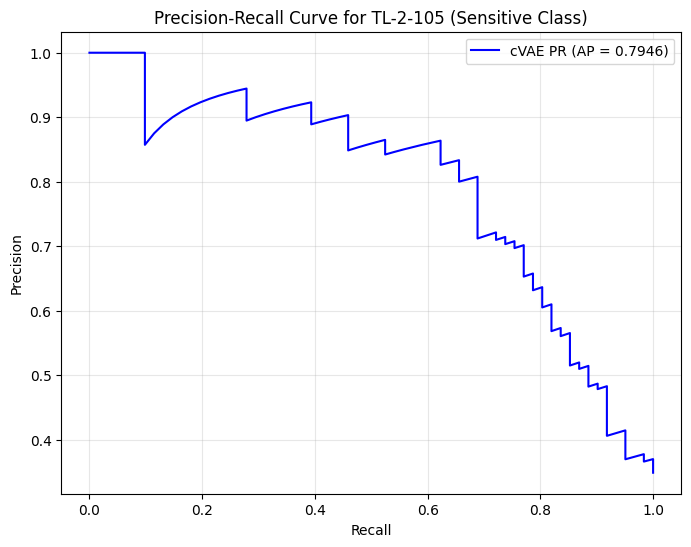

Plotting PR curve for drug: KIN001-260 (AP cVAE: 0.7946)


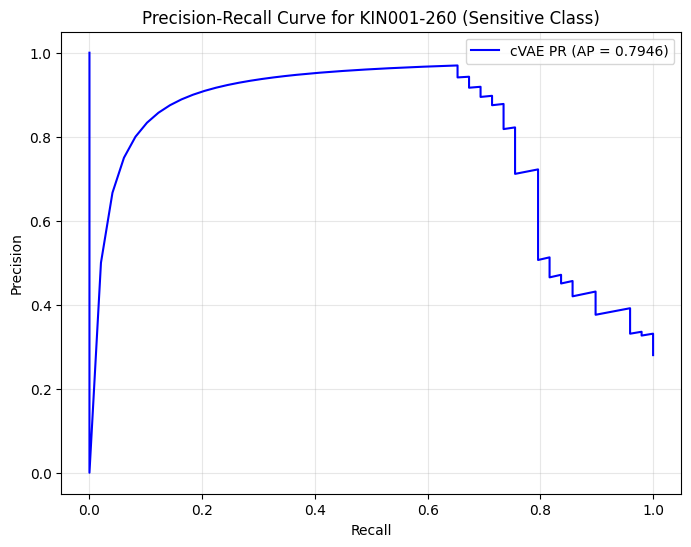

Plotting PR curve for drug: Methotrexate (AP cVAE: 0.7792)


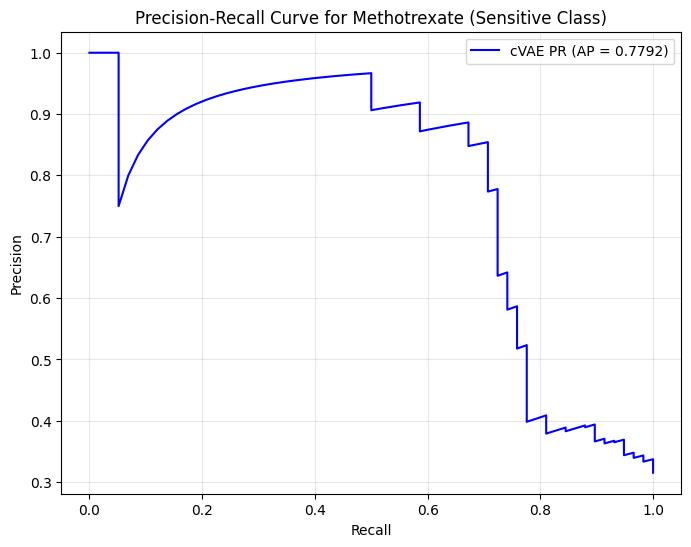

Plotting ROC curve for drug: KIN001-260 (AUROC cVAE: 0.8790)


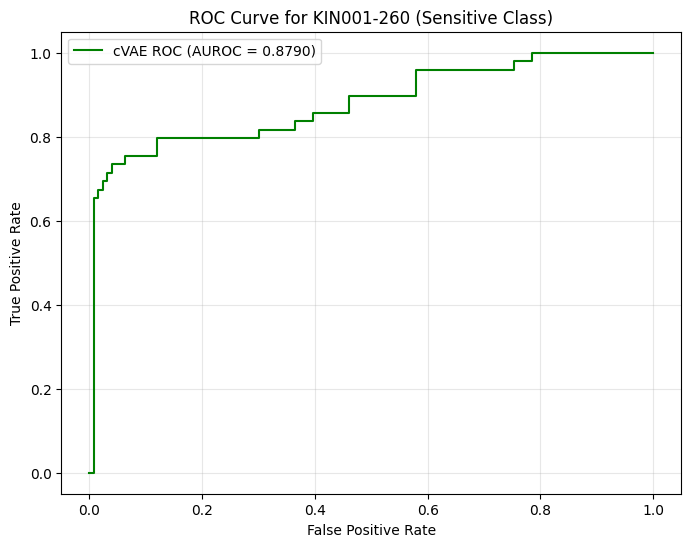

Plotting ROC curve for drug: Vorinostat (AUROC cVAE: 0.8652)


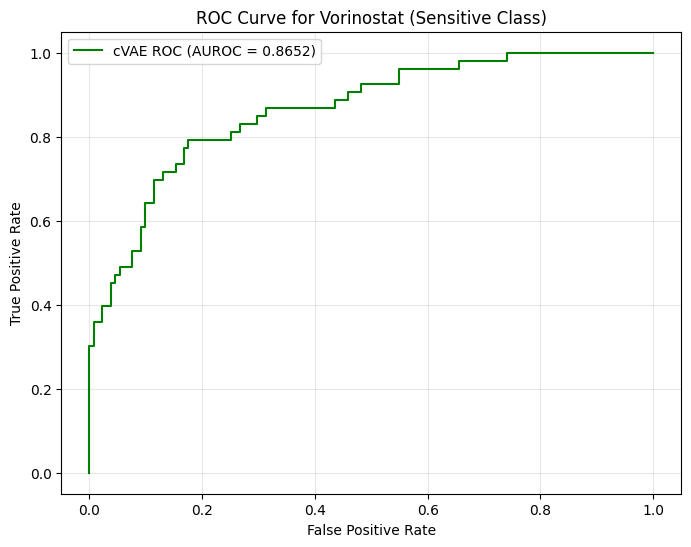

Plotting ROC curve for drug: Dasatinib (AUROC cVAE: 0.8588)


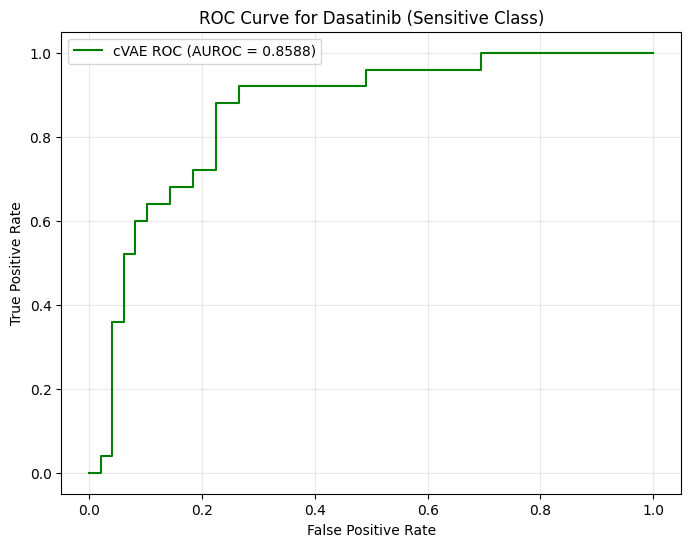

In [ ]:
import torch
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Helper function to perform Kernel Ridge Regression using Torch
def conditional_kernel_ridge_regression(X_train_cond, y_train_cond, X_test_cond, alpha=1.0, gamma=0.1):
    # Compute the RBF kernel
    K_train_cond = torch.exp(-gamma * torch.cdist(X_train_cond, X_train_cond) ** 2)
    K_test_cond = torch.exp(-gamma * torch.cdist(X_test_cond, X_train_cond) ** 2)

    # Compute alpha (ridge) regularized weights
    n = K_train_cond.size(0)
    ridge = alpha * torch.eye(n, device='cuda')
    alpha_weights_cond = torch.linalg.solve(K_train_cond + ridge, y_train_cond)

    # Predict on test data
    y_pred_cond = K_test_cond @ alpha_weights_cond
    return y_pred_cond

# Set paths and parameters
n_splits = 5
drug_pr_data = {}
average_precision_values_cvae = []
roc_auc_values_cvae = []
train_roc_auc_values = []

# Perform K-fold cross-validation
for fold in range(1, n_splits + 1):
    print(f"Processing fold {fold}/{n_splits}")

    # Load train and test latent vectors for this fold (conditional VAE)
    train_cond_path = f'/content/drive/MyDrive/Colab Notebooks/ECSE 556/FinalProject/output/ablation/cnv_mutation_latent_vectors_train_latent=15_fold={fold}.csv'
    test_cond_path = f'/content/drive/MyDrive/Colab Notebooks/ECSE 556/FinalProject/output/ablation/cnv_mutation_latent_vectors_test_latent=15_fold={fold}.csv'

    df_train_cond = pd.read_csv(train_cond_path, index_col='Unnamed: 0')
    df_test_cond = pd.read_csv(test_cond_path, index_col='Unnamed: 0')

    # Filter preprocessed `df_GDSC_filtered` for matching SANGER_MODEL_IDs
    matching_cond_ids = set(df_train_cond.index).union(set(df_test_cond.index))
    df_GDSC_cond_fold = df_GDSC_filtered[df_GDSC_filtered['SANGER_MODEL_ID'].isin(matching_cond_ids)]

    # Merge GDSC data with train and test latent vectors
    df_train_cond_merged = pd.merge(df_train_cond, df_GDSC_cond_fold, left_index=True, right_on='SANGER_MODEL_ID', how='inner')
    df_test_cond_merged = pd.merge(df_test_cond, df_GDSC_cond_fold, left_index=True, right_on='SANGER_MODEL_ID', how='inner')

    # Loop over each unique drug and collect predictions and labels across folds
    for drug in df_GDSC_cond_fold['DRUG_NAME'].unique():
        print(f"  Processing drug: {drug}")

        # Initialize storage for each drug if not already initialized
        if drug not in drug_pr_data:
            drug_pr_data[drug] = {"y_true": [], "y_pred": [], "train_auc": []}

        # Filter data for the current drug
        df_train_drug_cond = df_train_cond_merged[df_train_cond_merged['DRUG_NAME'] == drug]
        df_test_drug_cond = df_test_cond_merged[df_test_cond_merged['DRUG_NAME'] == drug]

        # Extract features and target (binary labels: sensitive vs. others)
        X_train_cond = df_train_drug_cond.drop(columns=['SANGER_MODEL_ID', 'DRUG_ID', 'DRUG_NAME', 'Sensitivity_Label', 'Normalized_IC50']).values
        y_train_labels = (df_train_drug_cond['Sensitivity_Label'] == 'sensitive').astype(int).values
        X_test_cond = df_test_drug_cond.drop(columns=['SANGER_MODEL_ID', 'DRUG_ID', 'DRUG_NAME', 'Sensitivity_Label', 'Normalized_IC50']).values
        y_test_labels = (df_test_drug_cond['Sensitivity_Label'] == 'sensitive').astype(int).values

        # Standardize features
        scaler_cond = StandardScaler()
        X_train_cond_scaled = scaler_cond.fit_transform(X_train_cond)
        X_test_cond_scaled = scaler_cond.transform(X_test_cond)

        # Convert data to torch tensors and transfer to GPU
        X_train_cond_tensor = torch.tensor(X_train_cond_scaled, dtype=torch.float32, device='cuda')
        y_train_labels_tensor = torch.tensor(y_train_labels, dtype=torch.float32, device='cuda')
        X_test_cond_tensor = torch.tensor(X_test_cond_scaled, dtype=torch.float32, device='cuda')

        # Perform Kernel Ridge Regression
        y_train_pred_cond_tensor = conditional_kernel_ridge_regression(X_train_cond_tensor, y_train_labels_tensor, X_train_cond_tensor)
        y_train_pred_cond = y_train_pred_cond_tensor.cpu().detach().numpy()

        y_test_pred_cond_tensor = conditional_kernel_ridge_regression(X_train_cond_tensor, y_train_labels_tensor, X_test_cond_tensor)
        y_test_pred_cond = y_test_pred_cond_tensor.cpu().detach().numpy()

        # Calculate train AUROC
        if len(np.unique(y_train_labels)) > 1:
            train_roc_auc = roc_auc_score(y_train_labels, y_train_pred_cond)
            train_roc_auc_values.append(train_roc_auc)

        # Append the predictions and labels for the current drug
        drug_pr_data[drug]["y_true"].extend(y_test_labels)
        drug_pr_data[drug]["y_pred"].extend(y_test_pred_cond)

        # Calculate precision-recall data and AUPR
        precision, recall, _ = precision_recall_curve(y_test_labels, y_test_pred_cond)
        ap_score = average_precision_score(y_test_labels, y_test_pred_cond)
        average_precision_values_cvae.append(ap_score)

        # Calculate AUROC
        if len(np.unique(y_test_labels)) > 1:  # Ensure both classes are present
            roc_auc = roc_auc_score(y_test_labels, y_test_pred_cond)
            roc_auc_values_cvae.append(roc_auc)

        # Save precision, recall, and ROC data
        drug_pr_data[drug]["precision"] = precision
        drug_pr_data[drug]["recall"] = recall
        drug_pr_data[drug]["fpr"], drug_pr_data[drug]["tpr"], _ = roc_curve(y_test_labels, y_test_pred_cond)
        drug_pr_data[drug]["average_precision"] = ap_score
        drug_pr_data[drug]["roc_auc"] = roc_auc

# Calculate averages
avg_train_roc_auc = np.mean(train_roc_auc_values)
avg_test_roc_auc = np.mean(roc_auc_values_cvae)
avg_test_aupr = np.mean(average_precision_values_cvae)

print(f"\nAverage Training AUROC: {avg_train_roc_auc:.4f}")
print(f"Average Test AUROC: {avg_test_roc_auc:.4f}")
print(f"Average Test AUPR: {avg_test_aupr:.4f}")

# Plot PR curves for the top 3 drugs
pr_scores_cvae = sorted([(drug, data["average_precision"]) for drug, data in drug_pr_data.items()], key=lambda x: x[1], reverse=True)
for i, (drug, ap_cvae) in enumerate(pr_scores_cvae[:3]):
    print(f"Plotting PR curve for drug: {drug} (AP cVAE: {ap_cvae:.4f})")
    precision = drug_pr_data[drug]["precision"]
    recall = drug_pr_data[drug]["recall"]
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"cVAE PR (AP = {ap_cvae:.4f})", color='blue')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for {drug} (Sensitive Class)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Plot ROC curves for the top 3 drugs
roc_scores_cvae = sorted([(drug, data["roc_auc"]) for drug, data in drug_pr_data.items()], key=lambda x: x[1], reverse=True)
for i, (drug, roc_auc) in enumerate(roc_scores_cvae[:3]):
    print(f"Plotting ROC curve for drug: {drug} (AUROC cVAE: {roc_auc:.4f})")
    fpr = drug_pr_data[drug]["fpr"]
    tpr = drug_pr_data[drug]["tpr"]
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"cVAE ROC (AUROC = {roc_auc:.4f})", color='green')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {drug} (Sensitive Class)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


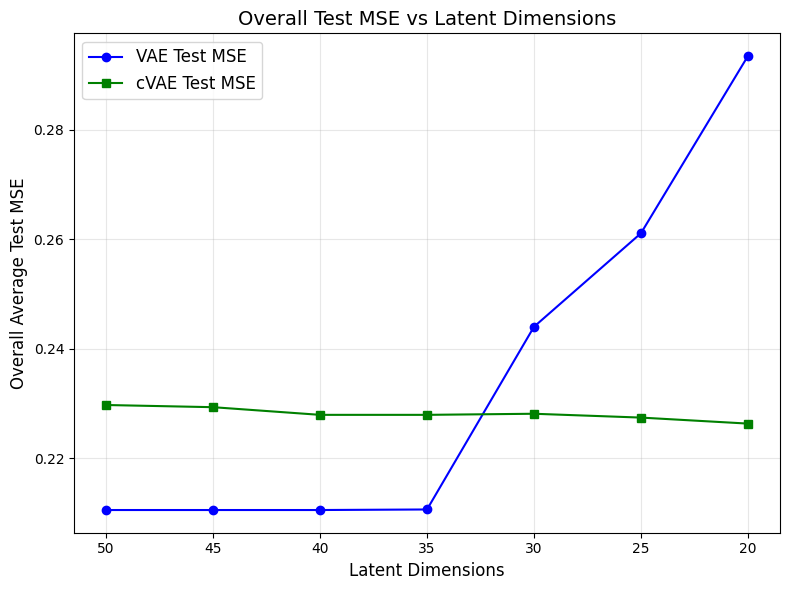

In [ ]:
'''
Latent = 50
VAE:
Overall Average Train MSE: 0.20977259783460994
Overall Average Test MSE: 0.2105256290939737
cVAE:
cVAE:
Overall Average Train MSE: 0.0849
Overall Average Test MSE: 0.2297
Average AUROC across all drugs: 0.6152

Latent = 45
VAE:
Overall Average Train MSE: 0.2097835142050402
Overall Average Test MSE: 0.21051312309599926
cVAE:
Overall Average Train MSE: 0.0896
Overall Average Test MSE: 0.2293
Average AUROC across all drugs: 0.6277

Latent = 40
VAE:
Overall Average Train MSE: 0.2095835142050402
Overall Average Test MSE: 0.21054313309599926
cVAE:
Overall Average Train MSE: 0.1031
Overall Average Test MSE: 0.2279
Average AUROC across all drugs: 0.6288

Latent = 35
VAE:
Overall Average Train MSE: 0.2096199586898952
Overall Average Test MSE: 0.21056787911100608
cVAE:
Overall Average Train MSE: 0.0994
Overall Average Test MSE: 0.2279
Average AUROC across all drugs: 0.6366

Latent = 30
VAE:
Overall Average Train MSE: 0.16107340106722962
Overall Average Test MSE: 0.244004643318697
cVAE:
Overall Average Train MSE: 0.1181
Overall Average Test MSE: 0.2281
Average AUROC across all drugs: 0.6410

Latent = 25
VAE:
Overall Average Train MSE: 0.1364853605594475
Overall Average Test MSE: 0.26106174112275365
cVAE:
Overall Average Train MSE: 0.1269
Overall Average Test MSE: 0.2274
Average AUROC across all drugs: 0.6437

Latent = 20
VAE:
Overall Average Train MSE: 0.10328345456503411
Overall Average Test MSE: 0.2935430407814609
cVAE:
Overall Average Train MSE: 0.1421
Overall Average Test MSE: 0.2263
Average AUROC across all drugs: 0.6474

'''
import matplotlib.pyplot as plt

# Data
latent_dims = [50, 45, 40, 35, 30, 25, 20]
vae_test_mse = [0.2105, 0.2105, 0.2105, 0.2106, 0.2440, 0.2611, 0.2935]
cvae_test_mse = [0.2297, 0.2293, 0.2279, 0.2279, 0.2281, 0.2274, 0.2263]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(latent_dims, vae_test_mse, marker='o', label='VAE Test MSE', color='blue')
plt.plot(latent_dims, cvae_test_mse, marker='s', label='cVAE Test MSE', color='green')

# Formatting
plt.xlabel("Latent Dimensions", fontsize=12)
plt.ylabel("Overall Average Test MSE", fontsize=12)
plt.title("Overall Test MSE vs Latent Dimensions", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.gca().invert_xaxis()  # To show higher latent dimensions on the left
plt.tight_layout()

# Show plot
plt.show()
